# Model Training

### 1.1 Import Data and Required Packages

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score,precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import warnings

#### Import the csv data as pandas dataframe

In [2]:
data = pd.read_csv('Data\digital_marketing_campaign_dataset.csv')

In [3]:
data.select_dtypes(include='object').columns

Index(['Gender', 'CampaignChannel', 'CampaignType', 'AdvertisingPlatform',
       'AdvertisingTool'],
      dtype='object')

#### show top 5 data

In [4]:
data.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [5]:
data['Conversion'].value_counts()

Conversion
1    7012
0     988
Name: count, dtype: int64

#### There is a Data imabalnce in our dataset it can Overfiting our model

## Balancing The data

In [6]:
class_1_data = data[data['Conversion'] == 1]
sampled_class_1_data, _ = train_test_split(class_1_data,train_size=988,stratify=class_1_data['Conversion'],random_state=42)

result = pd.concat([sampled_class_1_data, data[data['Conversion'] == 0]])
data = result.sample(frac=1, random_state=42).reset_index(drop=True)

### Handling Class Imbalance Using Stratified Sampling

To address the class imbalance in the dataset, the following steps were taken:

#### 1. **Extracting Class 1 Data**
The subset of data where `Conversion = 1` (minority class) was isolated to focus on balancing the dataset.

#### 2. **Stratified Sampling**
Stratified sampling was applied to the class 1 data, where 988 instances were sampled, matching the number of instances in class 0 (`Conversion = 0`). This ensures both classes are represented equally.

#### 3. **Combining Class 0 and Class 1 Data**
The 988 sampled instances from class 1 were combined with all class 0 data, resulting in a balanced dataset with an equal representation of both classes (total of 1976 instances).

#### 4. **Shuffling the Dataset**
The combined dataset was shuffled to ensure randomness and prevent any inherent order in the data, improving model training.

By using these techniques, a balanced dataset was created, reducing the risk of bias in machine learning models and improving their overall performance.
 

## Feature Engineering

In [7]:
data['EmailEngagement'] = data['EmailOpens'] + data['EmailClicks']
data['SiteEngagement'] = data['WebsiteVisits'] * data['PagesPerVisit'] * data['TimeOnSite']
data['IncomePerClick'] = data['Income'] / (data['ClickThroughRate'] + 1)  
data['AdSpendPerClick'] = data['AdSpend'] / (data['ClickThroughRate'] + 1)  
data['ClickToConversionRate'] = data['ConversionRate'] / (data['ClickThroughRate'] + 1) 
data['TotalInteractions'] = data['WebsiteVisits'] + data['EmailOpens'] + data['EmailClicks'] + data['SocialShares'] + data['PreviousPurchases']

#### Engineered a six new columns base on existing column. that helps to increase an accuracy of model

In [8]:
data.shape

(1976, 26)

In [9]:
data.select_dtypes(exclude='object').columns

Index(['CustomerID', 'Age', 'Income', 'AdSpend', 'ClickThroughRate',
       'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite',
       'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases',
       'LoyaltyPoints', 'Conversion', 'EmailEngagement', 'SiteEngagement',
       'IncomePerClick', 'AdSpendPerClick', 'ClickToConversionRate',
       'TotalInteractions'],
      dtype='object')

#### Total features in data set

In [10]:
data.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,EmailEngagement,SiteEngagement,IncomePerClick,AdSpendPerClick,ClickToConversionRate,TotalInteractions
0,15663,59,Male,81407,Referral,Conversion,1243.687722,0.118276,0.186211,48,...,2789,IsConfid,ToolConfid,0,9,5216.627852,72796.866583,1112.147225,0.166516,102
1,15487,20,Male,84046,Social Media,Consideration,6158.098703,0.234756,0.145429,20,...,1914,IsConfid,ToolConfid,0,25,2027.408223,68066.891173,4987.300220,0.117780,127
2,10974,27,Male,78786,SEO,Awareness,4490.310586,0.261984,0.161131,45,...,3479,IsConfid,ToolConfid,1,19,4120.550996,62430.290062,3558.137135,0.127680,143
3,14383,44,Female,21525,Referral,Consideration,1727.783854,0.243896,0.052483,29,...,3948,IsConfid,ToolConfid,1,15,3647.558707,17304.507564,1389.010396,0.042192,94
4,15465,55,Male,118987,Social Media,Retention,1556.484873,0.027868,0.178856,0,...,916,IsConfid,ToolConfid,0,13,0.000000,115760.973868,1514.284793,0.174007,25


In [11]:
x = data.drop(columns=['CustomerID','AdvertisingPlatform','AdvertisingTool','Conversion'])
y = data['Conversion']

In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1976 non-null   int64  
 1   Gender                 1976 non-null   object 
 2   Income                 1976 non-null   int64  
 3   CampaignChannel        1976 non-null   object 
 4   CampaignType           1976 non-null   object 
 5   AdSpend                1976 non-null   float64
 6   ClickThroughRate       1976 non-null   float64
 7   ConversionRate         1976 non-null   float64
 8   WebsiteVisits          1976 non-null   int64  
 9   PagesPerVisit          1976 non-null   float64
 10  TimeOnSite             1976 non-null   float64
 11  SocialShares           1976 non-null   int64  
 12  EmailOpens             1976 non-null   int64  
 13  EmailClicks            1976 non-null   int64  
 14  PreviousPurchases      1976 non-null   int64  
 15  Loya

#### Drop Unwanted and useless feature based on EDA

In [13]:
x.shape

(1976, 22)

### Data Preprocessing

In [14]:
# Create Column Transformer with 3 types of transformers
num_features = x.select_dtypes(exclude="object").columns
cat_features = x.select_dtypes(include="object").columns

numeric_transformer = StandardScaler(with_mean=False)
oh_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

#### creating pipeline that perform encoding and scaling on feature

In [15]:
X = preprocessor.fit_transform(x)

## Data Augmentation

In [16]:
smote = SMOTE(sampling_strategy={0: 4000, 1: 4000}, random_state=42)
X,y = smote.fit_resample(X, y)

### Augmanting Data Using SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) was applied to Generate data for achive heigh accuracy both classes to 4000 instances each. This ensures equal representation of both classes, helping to mitigate class imbalance. The `fit_resample` method was used to generate the balanced dataset.


## Data Spliting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### Spliting the data into train dataset and test dataset

#### Trainig all models and get their accuracy

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting Classifier": GradientBoostingClassifier(learning_rate=0.1, n_estimators=100),
    "XGBClassifier": XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42),
    "K-Neighbors Classifier": KNeighborsClassifier(n_neighbors=3),
    "Super Vector Machine" : SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

model_list = []
accuracy_list = []
precision_list = []
recall_list = []

for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')  # 'weighted' for multiclass
    recall_test = recall_score(y_test, y_test_pred, average='weighted')

    # Confusion matrix (optional)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Print results
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(accuracy_train))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(accuracy_test))
    print("- Precision: {:.4f}".format(precision_test))
    print("- Recall: {:.4f}".format(recall_test))

    print('Confusion Matrix:')
    print(conf_matrix)

    # Append test metrics for comparison
    accuracy_list.append(accuracy_test)
    precision_list.append(precision_test)
    recall_list.append(recall_test)

    print('=' * 35)
    print('\n')



Super Vector Machine
Model performance for Training set
- Accuracy: 0.8425
----------------------------------
Model performance for Test set
- Accuracy: 0.8100
- Precision: 0.8136
- Recall: 0.8100
Confusion Matrix:
[[595 196]
 [108 701]]




### Results

In [20]:

results_df = pd.DataFrame(list(zip(model_list, accuracy_list, precision_list, recall_list)),columns=['Model Name', 'Accuracy', 'Precision', 'Recall']).sort_values(by=["Accuracy"], ascending=False)
results_df


,Model Name,Accuracy,Precision,Recall
5,K-Neighbors Classifier,0.976875,0.976909,0.976875
2,Random Forest Classifier,0.954375,0.954390,0.954375
4,XGBClassifier,0.929375,0.929599,0.929375
1,Decision Tree,0.852500,0.852716,0.852500
3,Gradient Boosting Classifier,0.814375,0.815174,0.814375
6,Super Vector Machine,0.810000,0.813568,0.810000
7,AdaBoost Classifier,0.741875,0.743222,0.741875
0,Logistic Regression,0.719375,0.719541,0.719375


## KNeighbors Classifier

### Model Train

In [33]:
random_model = KNeighborsClassifier(n_neighbors=3)
random_model = random_model.fit(X_train, y_train)
y_pred = random_model.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",confusion)

 Accuracy of the model is 97.69
Confusion Matrix: [[769  22]
 [ 15 794]]


### Confusion Matrix

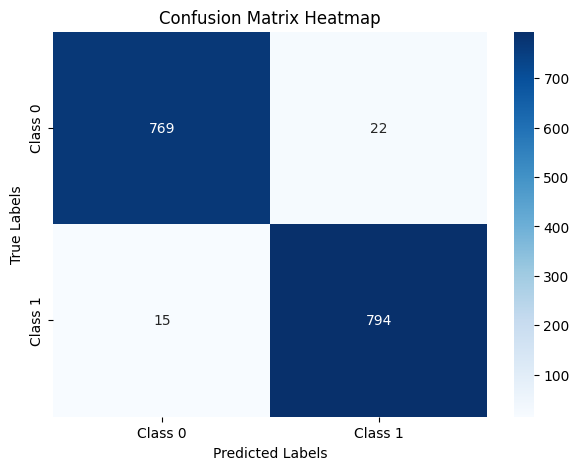

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.savefig('Confusion matrix')
plt.show()

### Observations:

- The model has a high accuracy in predicting both Class 0 and Class 1.

- The model is better at predicting Class 1 (higher True Positive rate) than Class 0 (lower True Negative rate).

- The model has a relatively low False Positive rate, indicating it is not likely to misclassify a Class 0 instance as Class 1.

- The model has a moderate False Negative rate, suggesting it is not consistently accurate in identifying Class 1 instances.

### AUC - ROC Curve

In [35]:

y_prob = random_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9937


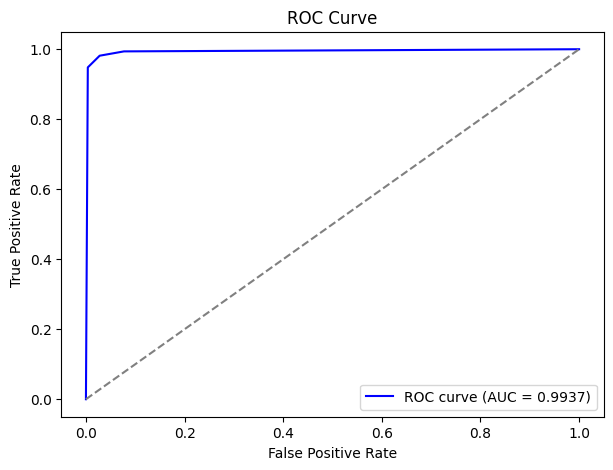

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# plt.savefig('auc or roc curve')
plt.show()

### Observesion

- **High AUC Score:** The AUC (Area Under the Curve) of 0.9915 suggests excellent model performance in distinguishing between positive and negative cases.

- **Steep Curve:** The ROC curve is very steep, indicating a strong ability to correctly classify positive instances while minimizing false positives.

- **Close to Ideal:** The curve is close to the top left corner, which represents an ideal classifier with high true positive rates and low false positive rates.